In [0]:
#### 
#### Dl assignment --> 2 
##$ Pramod Yadav

In [0]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader, TensorDataset, SequentialSampler, RandomSampler
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split


In [0]:
no_of_epochs = 25
btch_size = 32
lrn_rate = 0.0002
adam_d_beta_1 = 0.5
adam_d_beta_2 = 0.999
no_cpu_thr = 8
latent_dims = 100
img_dims = 128
img_chnls_dims = (3, 128, 128)
no_img_chnls = 3
int_btw_img_smpls = 50

In [0]:
os.makedirs("images", exist_ok=True)

In [0]:
cuda = True if torch.cuda.is_available() else False

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dims, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_chnls_dims))),
            nn.Tanh()
        )
        self.avgpool =  nn.AdaptiveAvgPool2d(1)

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_chnls_dims)
        return img


In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_chnls_dims)), 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)

        return validity

In [0]:
# Loss function
loss_func = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    loss_func.cuda()

In [0]:
# Optimizers
optimizer_Gen = torch.optim.Adam(generator.parameters(), lr=lrn_rate, betas=(adam_d_beta_1, adam_d_beta_2))
optimizer_Disc = torch.optim.Adam(discriminator.parameters(), lr=lrn_rate, betas=(adam_d_beta_1, adam_d_beta_2))


In [0]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

img_dir = '/home/pramod/planet/DL/Assign_2/faces94'

imgS_1 = glob(f"{img_dir}/**/**/*.jpg")

In [0]:
imgS_1[:10]

3059


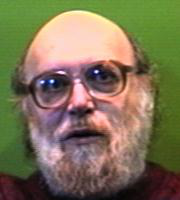

In [0]:
print(len(imgS_1))
Image.open(imgS_1[1])

In [0]:
labels = {"female" : 0, "male" : 1, "malestaff" : 2}

In [0]:
transform_loader = transforms.Compose([transforms.RandomResizedCrop((128,128)),transforms.RandomHorizontalFlip(),transforms.RandomRotation(10),transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])

imgS_2 = torch.stack([transform_loader(Image.open(i)) for i in imgS_1])

labels_2 = torch.tensor([labels[i.split('/')[-3]] for i in imgS_1])

trainData, testData = train_test_split(range(len(imgS_2)), test_size = 0.2, random_state = 102)

trainData_imgS = imgS_2[trainData]
trainData_labels = labels_2[trainData]

testData_imgS = imgS_2[testData]
testData_labels = labels_2[testData]

trainDataTensor = TensorDataset(trainData_imgS,trainData_labels)
testDataTensor = TensorDataset(testData_imgS,testData_labels)

trainDataSmpls = RandomSampler(trainDataTensor)
testDataSmpls = SequentialSampler(testDataTensor)

trainDataLoader = DataLoader(trainDataTensor, sampler=trainDataSmpls, batch_size=btch_size)
testDataLoader = DataLoader(testDataTensor, sampler=testDataSmpls, batch_size=btch_size)
print("done")

done


In [0]:
for epoch in range(no_of_epochs):
    for i, (imgs, _) in enumerate(trainDataLoader):

        # Ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_Gen.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dims))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        gen_loss = loss_func(discriminator(gen_imgs), valid)

        gen_loss.backward()
        optimizer_Gen.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_Disc.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_img_loss = loss_func(discriminator(real_imgs), valid)
        fake_img_loss = loss_func(discriminator(gen_imgs.detach()), fake)
        disc_loss = (real_img_loss + fake_img_loss) / 2

        disc_loss.backward()
        optimizer_Disc.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [disriminator_loss: %f] [generator_loss: %f]"
            % (epoch+1, no_of_epochs, i+1, len(trainDataLoader), disc_loss.item(), gen_loss.item())
        )

        batches_done = epoch * len(trainDataLoader) + i
        if batches_done % int_btw_img_smpls == 0:
            save_image(gen_imgs.data[:25], "images/gan_e"+str(no_of_epochs)+"_"+str(epoch+1)+"_%d.png" % batches_done, nrow=5, normalize=True)


[Epoch 1/10] [Batch 1/77] [disriminator_loss: 0.673281] [generator_loss: 0.681318]
[Epoch 1/10] [Batch 2/77] [disriminator_loss: 0.413357] [generator_loss: 0.683882]
[Epoch 1/10] [Batch 3/77] [disriminator_loss: 0.406361] [generator_loss: 0.695889]
[Epoch 1/10] [Batch 4/77] [disriminator_loss: 0.355246] [generator_loss: 0.709523]
[Epoch 1/10] [Batch 5/77] [disriminator_loss: 0.347696] [generator_loss: 0.725680]
[Epoch 1/10] [Batch 6/77] [disriminator_loss: 0.331841] [generator_loss: 0.744748]
[Epoch 1/10] [Batch 7/77] [disriminator_loss: 0.318212] [generator_loss: 0.772722]
[Epoch 1/10] [Batch 8/77] [disriminator_loss: 0.299974] [generator_loss: 0.803553]
[Epoch 1/10] [Batch 9/77] [disriminator_loss: 0.306128] [generator_loss: 0.836007]
[Epoch 1/10] [Batch 10/77] [disriminator_loss: 0.271793] [generator_loss: 0.870790]
[Epoch 1/10] [Batch 11/77] [disriminator_loss: 0.267025] [generator_loss: 0.898713]
[Epoch 1/10] [Batch 12/77] [disriminator_loss: 0.255782] [generator_loss: 0.918729]
[

[Epoch 2/10] [Batch 22/77] [disriminator_loss: 0.456366] [generator_loss: 0.513426]
[Epoch 2/10] [Batch 23/77] [disriminator_loss: 0.380206] [generator_loss: 0.633155]
[Epoch 2/10] [Batch 24/77] [disriminator_loss: 0.342061] [generator_loss: 0.765639]
[Epoch 2/10] [Batch 25/77] [disriminator_loss: 0.377210] [generator_loss: 0.793681]
[Epoch 2/10] [Batch 26/77] [disriminator_loss: 0.392980] [generator_loss: 0.615354]
[Epoch 2/10] [Batch 27/77] [disriminator_loss: 0.382819] [generator_loss: 0.625962]
[Epoch 2/10] [Batch 28/77] [disriminator_loss: 0.335047] [generator_loss: 0.719503]
[Epoch 2/10] [Batch 29/77] [disriminator_loss: 0.305885] [generator_loss: 0.854237]
[Epoch 2/10] [Batch 30/77] [disriminator_loss: 0.294433] [generator_loss: 0.827851]
[Epoch 2/10] [Batch 31/77] [disriminator_loss: 0.308830] [generator_loss: 0.864887]
[Epoch 2/10] [Batch 32/77] [disriminator_loss: 0.334335] [generator_loss: 0.720691]
[Epoch 2/10] [Batch 33/77] [disriminator_loss: 0.304623] [generator_loss: 0.

[Epoch 3/10] [Batch 43/77] [disriminator_loss: 0.348616] [generator_loss: 0.701868]
[Epoch 3/10] [Batch 44/77] [disriminator_loss: 0.292571] [generator_loss: 0.846405]
[Epoch 3/10] [Batch 45/77] [disriminator_loss: 0.448551] [generator_loss: 1.084732]
[Epoch 3/10] [Batch 46/77] [disriminator_loss: 0.575980] [generator_loss: 0.386109]
[Epoch 3/10] [Batch 47/77] [disriminator_loss: 0.531786] [generator_loss: 0.426594]
[Epoch 3/10] [Batch 48/77] [disriminator_loss: 0.405275] [generator_loss: 0.598510]
[Epoch 3/10] [Batch 49/77] [disriminator_loss: 0.317817] [generator_loss: 0.944950]
[Epoch 3/10] [Batch 50/77] [disriminator_loss: 0.677185] [generator_loss: 1.001055]
[Epoch 3/10] [Batch 51/77] [disriminator_loss: 0.716505] [generator_loss: 0.295182]
[Epoch 3/10] [Batch 52/77] [disriminator_loss: 0.805501] [generator_loss: 0.259763]
[Epoch 3/10] [Batch 53/77] [disriminator_loss: 0.639341] [generator_loss: 0.357285]
[Epoch 3/10] [Batch 54/77] [disriminator_loss: 0.454178] [generator_loss: 0.

[Epoch 4/10] [Batch 64/77] [disriminator_loss: 0.278584] [generator_loss: 1.065506]
[Epoch 4/10] [Batch 65/77] [disriminator_loss: 0.300139] [generator_loss: 0.922091]
[Epoch 4/10] [Batch 66/77] [disriminator_loss: 0.375628] [generator_loss: 0.882905]
[Epoch 4/10] [Batch 67/77] [disriminator_loss: 0.414735] [generator_loss: 0.776247]
[Epoch 4/10] [Batch 68/77] [disriminator_loss: 0.453910] [generator_loss: 0.564509]
[Epoch 4/10] [Batch 69/77] [disriminator_loss: 0.516982] [generator_loss: 0.689376]
[Epoch 4/10] [Batch 70/77] [disriminator_loss: 0.510563] [generator_loss: 0.531686]
[Epoch 4/10] [Batch 71/77] [disriminator_loss: 0.539401] [generator_loss: 0.849102]
[Epoch 4/10] [Batch 72/77] [disriminator_loss: 0.608169] [generator_loss: 0.449245]
[Epoch 4/10] [Batch 73/77] [disriminator_loss: 0.490883] [generator_loss: 0.574805]
[Epoch 4/10] [Batch 74/77] [disriminator_loss: 0.454478] [generator_loss: 1.216629]
[Epoch 4/10] [Batch 75/77] [disriminator_loss: 0.348053] [generator_loss: 0.

[Epoch 6/10] [Batch 8/77] [disriminator_loss: 0.365632] [generator_loss: 0.849264]
[Epoch 6/10] [Batch 9/77] [disriminator_loss: 0.338664] [generator_loss: 0.897348]
[Epoch 6/10] [Batch 10/77] [disriminator_loss: 0.367816] [generator_loss: 0.851903]
[Epoch 6/10] [Batch 11/77] [disriminator_loss: 0.346980] [generator_loss: 0.922541]
[Epoch 6/10] [Batch 12/77] [disriminator_loss: 0.406212] [generator_loss: 0.755189]
[Epoch 6/10] [Batch 13/77] [disriminator_loss: 0.387872] [generator_loss: 0.783689]
[Epoch 6/10] [Batch 14/77] [disriminator_loss: 0.353008] [generator_loss: 0.837723]
[Epoch 6/10] [Batch 15/77] [disriminator_loss: 0.363781] [generator_loss: 0.791256]
[Epoch 6/10] [Batch 16/77] [disriminator_loss: 0.418329] [generator_loss: 1.011148]
[Epoch 6/10] [Batch 17/77] [disriminator_loss: 0.661529] [generator_loss: 0.390659]
[Epoch 6/10] [Batch 18/77] [disriminator_loss: 0.442663] [generator_loss: 0.704275]
[Epoch 6/10] [Batch 19/77] [disriminator_loss: 0.683253] [generator_loss: 1.39

[Epoch 7/10] [Batch 29/77] [disriminator_loss: 0.408359] [generator_loss: 0.898445]
[Epoch 7/10] [Batch 30/77] [disriminator_loss: 0.342641] [generator_loss: 1.031167]
[Epoch 7/10] [Batch 31/77] [disriminator_loss: 0.345838] [generator_loss: 0.808795]
[Epoch 7/10] [Batch 32/77] [disriminator_loss: 0.379906] [generator_loss: 1.034986]
[Epoch 7/10] [Batch 33/77] [disriminator_loss: 0.336008] [generator_loss: 0.905489]
[Epoch 7/10] [Batch 34/77] [disriminator_loss: 0.386571] [generator_loss: 1.112396]
[Epoch 7/10] [Batch 35/77] [disriminator_loss: 0.407210] [generator_loss: 0.657479]
[Epoch 7/10] [Batch 36/77] [disriminator_loss: 0.309702] [generator_loss: 1.040895]
[Epoch 7/10] [Batch 37/77] [disriminator_loss: 0.313664] [generator_loss: 1.227219]
[Epoch 7/10] [Batch 38/77] [disriminator_loss: 0.374952] [generator_loss: 0.812452]
[Epoch 7/10] [Batch 39/77] [disriminator_loss: 0.345960] [generator_loss: 1.058022]
[Epoch 7/10] [Batch 40/77] [disriminator_loss: 0.378019] [generator_loss: 0.

[Epoch 8/10] [Batch 50/77] [disriminator_loss: 0.305398] [generator_loss: 1.026756]
[Epoch 8/10] [Batch 51/77] [disriminator_loss: 0.380565] [generator_loss: 1.152695]
[Epoch 8/10] [Batch 52/77] [disriminator_loss: 0.455626] [generator_loss: 0.582760]
[Epoch 8/10] [Batch 53/77] [disriminator_loss: 0.378265] [generator_loss: 0.795354]
[Epoch 8/10] [Batch 54/77] [disriminator_loss: 0.430534] [generator_loss: 1.239529]
[Epoch 8/10] [Batch 55/77] [disriminator_loss: 0.425371] [generator_loss: 0.625829]
[Epoch 8/10] [Batch 56/77] [disriminator_loss: 0.399390] [generator_loss: 0.684312]
[Epoch 8/10] [Batch 57/77] [disriminator_loss: 0.398851] [generator_loss: 1.199481]
[Epoch 8/10] [Batch 58/77] [disriminator_loss: 0.331209] [generator_loss: 0.914370]
[Epoch 8/10] [Batch 59/77] [disriminator_loss: 0.367062] [generator_loss: 0.932890]
[Epoch 8/10] [Batch 60/77] [disriminator_loss: 0.397619] [generator_loss: 0.857726]
[Epoch 8/10] [Batch 61/77] [disriminator_loss: 0.361091] [generator_loss: 0.

[Epoch 9/10] [Batch 71/77] [disriminator_loss: 0.384592] [generator_loss: 0.978727]
[Epoch 9/10] [Batch 72/77] [disriminator_loss: 0.475949] [generator_loss: 0.780014]
[Epoch 9/10] [Batch 73/77] [disriminator_loss: 0.405237] [generator_loss: 0.697445]
[Epoch 9/10] [Batch 74/77] [disriminator_loss: 0.367513] [generator_loss: 1.165769]
[Epoch 9/10] [Batch 75/77] [disriminator_loss: 0.337634] [generator_loss: 0.813322]
[Epoch 9/10] [Batch 76/77] [disriminator_loss: 0.414191] [generator_loss: 1.004515]
[Epoch 9/10] [Batch 77/77] [disriminator_loss: 0.568893] [generator_loss: 0.484426]
[Epoch 10/10] [Batch 1/77] [disriminator_loss: 0.371846] [generator_loss: 0.970050]
[Epoch 10/10] [Batch 2/77] [disriminator_loss: 0.463964] [generator_loss: 1.288330]
[Epoch 10/10] [Batch 3/77] [disriminator_loss: 0.508718] [generator_loss: 0.506083]
[Epoch 10/10] [Batch 4/77] [disriminator_loss: 0.321672] [generator_loss: 0.975001]
[Epoch 10/10] [Batch 5/77] [disriminator_loss: 0.481967] [generator_loss: 1.